# Spatial display for Wetlands Insight Tool results <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with only the `NCI VDI` environment


* **Special requirements:** 
    * If running on the [NCI](https://nci.org.au/), ensure that `module load dea` is   run prior to launching this notebook
    * Check you have the latest version of the `wit_tooling package` by 
      copying and pasting the following code into a cell below and running the cell
    `!pip install --user git+git://github.com/GeoscienceAustralia/wit_tooling`
      
      
* **Products used:** 
    * Collection 2 Landsat Surface Reflectance: 
    [ls5_nbart_albers](https://explorer.dea.ga.gov.au/ls5_nbart_albers),
    [ls7_nbart_albers](https://explorer.dea.ga.gov.au/ls7_nbart_albers),
    [ls8_nbart_albers](https://explorer.dea.ga.gov.au/ls8_nbart_albers)
    * Collection 2 Landsat Fractional Cover, 
    generated using the Joint Remote Sensing Research Program algorithm: 
    [ls5_fc_albers](https://explorer.dea.ga.gov.au/ls5_fc_albers),
    [ls7_fc_albers](https://explorer.dea.ga.gov.au/ls7_fc_albers),
    [ls8_fc_albers](https://explorer.dea.ga.gov.au/ls8_fc_albers)
    * Water Observations from Space, 
    generated using the Geoscience Australia Algorithm:
    [wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers)



## Background
The Spatial Wetlands Insight Tool is a tool in development to display the coverage of water, "wetness" and vegetation fractional cover in a wetland spatially. It is generated off existing Wetlands Insight Tool temporal runs. 

## Description
This notebook uses an existing Wetlands Insight Tool temporal plot, 
generated from an existing WIT run, to create a spatial plot of water, "wetness", green/photosynthetic vegetation, dry/non-photosynthetic vegetation, and bare soil for a chosen observation date. 

1. First we load the existing WIT data from either: 
    * a saved csv location
    * a shapefile to retrieve the existing WIT data from the database of previous runs
    * a csv from an Amazon s3 data bucket
2. Then we choose a time of interest to plot Spatial WIT
3. Finally we output Spatial WIT to a file for each cover type
***

Before running this notebook:
-----------------------------
* Follow the instructions under `Special Requirements` above to load `dea` and install `wit_tooling`

In [1]:
#!pip install --user git+git://github.com/GeoscienceAustralia/wit_tooling

## Load packages

In [2]:
# import all the necessary packages in this cell
import pandas as pd
import numpy as np
import fiona
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt

from datacube.utils.cog import write_cog

from bokeh.io import curdoc, output_notebook, show, export_svgs
from bokeh.layouts import layout, row, column, grid, gridplot
from bokeh.models import (CheckboxGroup, Select, ColumnDataSource, HoverTool, YearsTicker, AdaptiveTicker, Legend,
                          CustomJS, LegendItem, field, Range1d, Circle, Button, RadioGroup, TextInput, WheelZoomTool,
                          ResetTool, BoxZoomTool, SaveTool, LinearColorMapper, Label)
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models.glyphs import Text
from bokeh.colors import RGB
from bokeh.plotting import figure
import datetime

from os import path
import os, sys, logging
import seaborn as sns
import ssl

from wit_tooling import load_wit_data, query_datasets, construct_product, load_wofs_fc, generate_raster, spatial_wit

In [3]:
output_notebook()
ssl._create_default_https_context = ssl._create_unverified_context

_LOG = logging.getLogger(__name__)
stdout_hdlr = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('[%(asctime)s.%(msecs)03d - %(levelname)s] %(message)s')
stdout_hdlr.setFormatter(formatter)
_LOG.addHandler(stdout_hdlr)
_LOG.setLevel(logging.DEBUG)

Loading BokehJS ...

### Global variables
If you are using a shapefile, csv file, or Amazon s3 link to the existing WIT run, 
the path must be set in the cell below this cell:

* `shapefile`: NCI path to shapefile 
(e.g. `'/g/data1a/r78/DEA_Wetlands/shapefiles/ramsar_wetlands_3577_20190403.shp'`). 
You must have permissions to the project directory,
and the shapefile must be in [Australian Albers EPSG 3577 projection](https://spatialreference.org/ref/epsg/gda94-australian-albers/)
* `csv_file`: NCI path to WIT results CSV (e.g. `'/g/data1a/u46/users/ea6141/dea-notebooks/Spatial_WIT/sample_data/Western Port_Western Port_VIC_19.csv'`)
* `pd_yaml`: Yaml file necessary to generate WIT 
e.g. `'/g/data/u46/users/ea6141/wit_tooling/aux/fc_pd.yaml'`). 
Specifies input datasets.
* `s3_url`: Amazon s3 url link to pre-generated WIT csvs folder 
(e.g. `'https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3'`). 


In [4]:
# put global variables in this cell
shapefile = '/g/data/r78/DEA_Wetlands/shapefiles/ramsar_wetlands_3577_20190403.shp'
#csv_file = '/g/data1a/u46/users/ea6141/dea-notebooks/Spatial_WIT/sample_data/Western Port_Western Port_VIC_19.csv'
pd_yaml = '/g/data1a/r78/rjd547/bin/wit_tooling/auxfiles/fc_pd.yaml'#'/g/data/u46/users/ea6141/wit_tooling/auxfiles/fc_pd.yaml'
s3_url = 'https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3/Kerang%20Wetlands_Hird%20Swamp_VIC_17.csv'

In [5]:
def save_geotiff(spatial_wit_xr, filename, force=False):
    """
        save spatial WIT result to geotiffs, each band will be output to individual tiff
        input:
            an xarray Dataset of spatial WIT
            overwrite existing file if force=True, otherwise no output
        output:
            multiple cloud-optimized geotiffs (cogs) on disk
    """
    for var in spatial_wit_xr.data_vars:       
        #create file name per band
        band_output = file_name + "_" + var + ".tif"
        if path.exists(band_output):
            _LOG.warning("output geotif %s exists", band_output)
            if force:
                _LOG.warning("existing geotif %s will be overwritten", band_output)
                os.remove(band_output)
            else:
                continue
        spatial_wit_xr[var].attrs.update(spatial_wit_xr.attrs)
        write_cog(spatial_wit_xr[var], band_output, blocksize=16)
    return

## Load WIT data using one of the methods in the cell below

In [6]:
# A list we wanna explore
#poly_candidates = {1: 1, 5: 5, 116: 116, 103: 103, 2: 2, 112: 112}
poly_candidates = {42:42}

In [7]:
# todo: iterate over all possible loading routes,
# i.e., database and csv on s3 (not responsible for local csv, users supposed to know)
# load wit data from database with a chosen shape
with fiona.open(shapefile) as allshapes:
    shape_crs = allshapes.crs_wkt
    shape_list = iter(allshapes)
    while True:
        shape = next(shape_list)
        if int(shape['id']) == poly_candidates[42]:
            break
    #polyName = shape['properties'].get('WetlandNam', '')
    poly_outline = np.array(shape['geometry']['coordinates'][0])
   # s3_filename = 'area_percent_' + shape['id'] + '_0.csv'
    wit_data = load_wit_data(s3_url='https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3/Kerang%20Wetlands_Hird%20Swamp_VIC_17.csv')

### Check the shapefile to make sure we've got the correct polygon

In [8]:
shape_df = gpd.read_file(shapefile)

In [9]:
shape_df[42:43]

,REFCODE,RAMSAR_NAM,WETLAND_NA,STATE,JURISDICTI,DESIGNATIO,TOTAL_SITE,GAZETTED_A,SOURCE,METADATA_U,WETLANDSDB,AREA_HA,geometry
42,17,Kerang Wetlands,Hird Swamp,VIC,VIC,1982-12-15,0.0,9419.0,Department of Environment and Primary Industri...,http://services.land.vic.gov.au/SpatialDatamar...,http://www.environment.gov.au/cgi-bin/wetlands...,433.68127,"POLYGON ((1090599.724 -3968110.105, 1090900.93..."


Hird Swamp


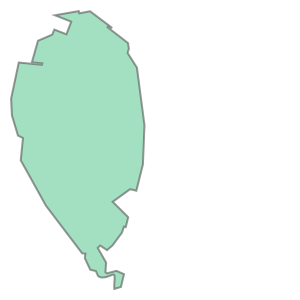

In [10]:
#Check that #42 is Hird Swamp
print(shape_df['WETLAND_NA'][42])
polyName = shape_df['WETLAND_NA'][42]
shape_df['geometry'][42]

### Spatial wit for the chosen shape

In [11]:
# it's helpful to get the location of data rather than load them
# and it will save you time without querying database multiple times
time_range = (wit_data.utc_time.min(), wit_data.utc_time.max())

In [12]:
#build a product for our data using the yaml file to specify which datasets we need
fc_product = construct_product(pd_yaml)
datasets = query_datasets(fc_product, shape, shape_crs, time_range)
_LOG.debug("Query datasets %s", datasets)

[2021-06-11 15:20:19,965.965 - DEBUG] Query datasets <VirtualDatasetBox of shape {'time': 1091, 'y': 152, 'x': 74}>


Retrieve spatial wit for the dates we have chosen to show in the WIT paper

In [13]:
#setup dates for the paper figure 
paper_dates = [datetime.date(1987,9,30),
              datetime.date(1998,4,30),
              datetime.date(1999,4,1),
              datetime.date(2009,4,4),
              datetime.date(2011,1,28),
              datetime.date(2017,9,26),
              datetime.date(2019,6,28)]

#convert the times (from the paper figure) into timestamps by finding the closest times, and hoping they match
paper_ixs = [abs(wit_data.utc_time-t).argmin() for t in pd.to_datetime(paper_dates)]

# take time slice to init spatial wit plot
time_slice = np.datetime64(wit_data.utc_time[paper_ixs[0]])
_LOG.debug("load time slice %s", time_slice)

#load the first data array for spatial wit
fc_wofs_data = load_wofs_fc(fc_product, datasets, time_slice)

[2021-06-11 15:20:20,004.004 - DEBUG] load time slice 1987-09-30T23:42:36.500000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


In [14]:
#set this into a loop to load into xarray. Start with the second one, as we are appending from here. 
#time_slices = [time_slice]

In [15]:
time_slices = [np.datetime64(wit_data.utc_time[paper_ixs[0]])]

In [16]:
for i in range(0,6):
    # set the time slice, load the time slice, then concatenate the arrays. 
    time_slice = np.datetime64(wit_data.utc_time[paper_ixs[i+1]])
    time_slices.append(time_slice)
    _LOG.debug("load time slice %s", time_slice)
    fc_wofs_data_new = load_wofs_fc(fc_product, datasets, time_slice)
    #add the new one to the existing one and hope it works
    fc_wofs_data = xr.concat([fc_wofs_data, fc_wofs_data_new],'time')

[2021-06-11 15:20:20,771.771 - DEBUG] load time slice 1998-04-30T23:46:24.500000
[2021-06-11 15:20:21,502.502 - DEBUG] load time slice 1999-04-01T23:47:56.500000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


[2021-06-11 15:20:22,170.170 - DEBUG] load time slice 2009-04-04T00:02:23.500000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


[2021-06-11 15:20:22,787.787 - DEBUG] load time slice 2011-01-28T23:59:10.500000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


[2021-06-11 15:20:23,430.430 - DEBUG] load time slice 2017-09-26T00:09:26.000000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


[2021-06-11 15:20:23,985.985 - DEBUG] load time slice 2019-06-28T00:09:07.000000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


mask spatial wit by the geometry of given polygon

In [17]:
# first parameter of generate_raster is a tuple of (shape geometry, [integer of shape id])
mask = generate_raster([(shape['geometry'], int(shape['id']))], datasets.geobox)
fc_wofs_perc = spatial_wit(fc_wofs_data, mask)

/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/utils/geometry/_base.py:301: DeprecationWarning: Please use `str(crs)` instead of `crs.crs_str`
  warnings.warn("Please use `str(crs)` instead of `crs.crs_str`", category=DeprecationWarning)


get our temporal wit data into a form that we can plot nicely

In [18]:
if wit_data.water.max() <= 1.0:
    #multiply our pandas bare, wet, green, dry, water by 100 to make plotting perc
    wit_data.iloc[:,1:] = wit_data[wit_data.columns[1:]].apply(lambda x: x * 100)

Create a wit temporal plot with wit spatial wit plots above it

In [19]:
'''code to create the WIT temporal and spatial plots '''
#tell bokeh the data comes from a pandas dataframe
source = ColumnDataSource(data=wit_data)

#bex genuinely has no idea what this does
for i in range(10):
    source.data['dummy'+str(i)] = np.ones(source.data['utc_time'].shape) * i * 10

#set up color palate for bokeh WIT plot
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]  

#set up a consistent font style throughout
FONTSIZE = "10pt"
FONTSTYLE = 'normal'


In [20]:
#set up the x axis to recognise date and time. Note that you will only see the days when you zoom in.
wit_plot = figure(plot_width=493,#700,#1400, 
          plot_height = 200, #282 #400
          x_axis_type='datetime',
          toolbar_location=None,
          #title=title, 
          tools="save")
    #["box_select", ResetTool(), BoxZoomTool(dimensions="width")])
hovernames = []
nonselected_circle = Circle(fill_alpha=0, fill_color=None, line_color=None)
for i in range(10):
    circle_group_name = 'circlegroup' + str(i)
    renderer = wit_plot.circle(y="dummy" + str(i), x= 'utc_time', size=20, fill_color=None, 
                    line_alpha=0, source = source, muted_color="white", muted_alpha=0, name=circle_group_name)
    renderer.nonselection_glyph = nonselected_circle
    hovernames.append(circle_group_name)
wit_plot.varea_stack(['water', 
              'wet',
              'green',
              'dry',
              'bare'], x= 'utc_time', name = "stackplot", color=pal, fill_alpha=0.7, source = source, 
              legend_label=["water","wet","green","dry","bare"], muted_color="grey", muted_alpha=0.2)
#wit_plot.sizing_mode = "scale_width"

#label axes
wit_plot.yaxis.axis_label=("Percentage of wetland (%)")
wit_plot.yaxis.axis_label_text_font_size=FONTSIZE
wit_plot.yaxis.axis_label_text_font_style=FONTSTYLE

wit_plot.xaxis.axis_label="Observation date"
wit_plot.xaxis.axis_label_text_font_size=FONTSIZE
wit_plot.xaxis.axis_label_text_font_style=FONTSTYLE

# #we need screen units to put the attribution label under the plot. Don't ask why.
# label_opts = dict(
#     x=0, 
#     y=0,
#     x_units='screen', 
#     y_units='screen',
#     #text_font_style="italic", 
#     text_font_style = 'normal',
#     text_font_size=FONTSIZE)

#set our desired axes number displays
wit_plot.xaxis.formatter=DatetimeTickFormatter()
wit_plot.xaxis.ticker = YearsTicker(interval=2, desired_num_ticks=30)
wit_plot.xaxis.major_tick_in =0
wit_plot.xaxis.major_label_orientation = 45
wit_plot.yaxis.ticker = AdaptiveTicker(desired_num_ticks=10)

#set the new WIT graph ranges
left, right, bottom, top = source.data['utc_time'][0], source.data['utc_time'][-1], 0, 100 #set 
wit_plot.x_range=Range1d(left, right)
wit_plot.y_range=Range1d(bottom, top)
wit_plot.xaxis.bounds=(left,right)
wit_plot.yaxis.bounds=(bottom,top)

#now we want to overplot the data on the plot
#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime.datetime(2011,11,1)
LS5_8_gap_end = datetime.datetime(2013,4,1)

#plot our dead satellite rectangle
wit_plot.hbar(y=50, 
       height=100,
       left=LS5_8_gap_start, 
       right=LS5_8_gap_end, 
       name ="LS7 SLC-OFF",
       color="white", 
       alpha=0.5, 
       hatch_color="white", 
       hatch_pattern='/',
       hatch_alpha=0.6,
       line_color="white",
       line_width =2,
       line_alpha=0.6)

wit_plot.legend.location="bottom_left"
wit_plot.legend.background_fill_alpha=0.5
wit_plot.legend.border_line_alpha=0.5
wit_plot.legend.label_text_font_size=FONTSIZE

#turn off gridlines in background
wit_plot.xgrid.grid_line_color = None
wit_plot.ygrid.grid_line_color = None

#reverse the legend 
wit_plot.legend[0].items.reverse()


In [47]:
#spatial wit plot

image_list = {}
color_map_dict = {}

# all below is to setup the pallete
transparent_white = RGB(255, 255, 255, 0)
colbat_blue = [RGB(3, 10, 167, 1)]
neon_blue = [RGB(4, 217, 255, 1)]
grass_green = [RGB(63, 155, 11, t) for t in np.arange(0.1, 1, 0.1)]
soil_brown = [RGB(96, 70, 15, t) for t in np.arange(0.1, 1, 0.1)]
dry_biege = [RGB(230, 218, 166, t) for t in np.arange(0.1, 1, 0.1) ]
var_colors = [soil_brown, grass_green, dry_biege, neon_blue, colbat_blue]

fig_row = [None]*len(paper_dates)
for time_idx in range(len(paper_dates)):
    for var, cm in zip(fc_wofs_perc.data_vars, var_colors):
        image_list[var] = [np.flip(fc_wofs_perc[var].data[time_idx], axis=0)]
        color_map_dict[var] = LinearColorMapper([transparent_white]+cm, low=0, high=100,
                                   nan_color=transparent_white)
    sw_source = ColumnDataSource(data=image_list)

    # set up the spatial wit plots
    #fig_row[time_idx] = figure(plot_width=70, plot_height = 105, toolbar_location=None)#(plot_width=100, plot_height = 150, toolbar_location=None)
    
    #export at twice the resolution for cartography
    fig_row[time_idx] = figure(plot_width=140, plot_height = 210, toolbar_location=None)#(plot_width=100, plot_height = 150, toolbar_location=None)
    #again, hacked to work for time index 0
    for var in fc_wofs_perc.isel(time=0).data_vars:
        fig_row[time_idx].image(image=var, source=sw_source, x=fc_wofs_data.x.data.min(), y=fc_wofs_data.y.data.min(),
            dh=(fc_wofs_data.y.data.max() - fc_wofs_data.y.data.min()),
            dw=(fc_wofs_data.x.data.max() - fc_wofs_data.x.data.min()),
            color_mapper = color_map_dict[var])
        
    fig_row[time_idx].line(poly_outline[:,0], poly_outline[:,1], line_width=2)#, line_color='black')
    fig_row[time_idx].y_range.update(start=poly_outline[:,1].min(), end=poly_outline[:,1].max())
    fig_row[time_idx].x_range.update(start=poly_outline[:,0].min(), end=poly_outline[:,0].max())

    fig_row[time_idx].title.text = "%s" % time_slices[time_idx].astype('datetime64[D]')
    fig_row[time_idx].title.text_font_size=FONTSIZE
    fig_row[time_idx].title.text_font_style=FONTSTYLE
    fig_row[time_idx].title.align="center"
    fig_row[time_idx].axis.visible = None
    fig_row[time_idx].min_border_left = 0  
    
    #turn off gridlines in background
    fig_row[time_idx].xgrid.grid_line_color = None
    fig_row[time_idx].ygrid.grid_line_color = None
    

### On your first run through this notebook go to a terminal and run this (won't work in notebook): 

In [22]:
#/g/data1a/r78/rjd547/install_source/geckodriver

In [48]:
from selenium import webdriver
# # you need geckodriver run in a terminal before this line, e.g., 
# # [ea6141@vdi-n12 install_source]$ ./geckodriver 
# # 1621915656584 geckodriver INFO    Listening on 127.0.0.1:4444

# #bex: done
# # [rjd547@vdi-n26 dea-notebooks]$ 
# #! /g/data1a/r78/rjd547/install_source/geckodriver
# # 1621920096698   geckodriver     INFO    Listening on 127.0.0.1:4444
driver = webdriver.Remote("127.0.0.1:4444")


SessionNotCreatedException: Message: Session is already started


In [40]:
layout = column(row(fig_row,  sizing_mode = 'fixed'), row(wit_plot, sizing_mode = 'fixed'))#'stretch_both'))

In [45]:
from bokeh.io import export_png
# show(layout, toolbar_location = None)

# # export the png
# export_png(layout, filename="Fig3HirdSw_d.png", webdriver=driver)

In [49]:
spatial_layout = column(row(fig_row,  sizing_mode = 'fixed'))
show(spatial_layout, toolbar_location = None)

# export the png
export_png(spatial_layout, filename="Fig3SpatialWit_i.png", webdriver=driver)

WebDriverException: Message: Failed to decode response from marionette


In [ ]:
# from bokeh.io import export_svgs

# export_svgs(spatial_layout, filename="plot.svg", webdriver=driver)

In [ ]:
# from bokeh.io import export_svg

# export_svg(spatial_layout, filename="plot2.svg", webdriver=driver)

In [ ]:
# save spatial WIT as geotiff
# each variable will be output to individual COG
# file_name works as prefix, the final output file name will be "file_name_bandname", e.g. "test_BS.tif"
# by default force=False := not overwriting existing geotif
# file_name = "test_" + str(time_slice)
# save_geotiff(fc_wofs_perc, file_name, force=False)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 16 2020

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`no_testing`,:index:`NCI compatible`,:index:`landsat 5`, :index:`landsat 7`,  :index:`landsat 8`, :index:`dea_plotting`, :index:`time series`